In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, Input,UpSampling2D, Reshape
from tensorflow.keras.models import Model, load_model
import tensorflow.keras as keras
from alibi.explainers import CounterfactualRL
#from alibi.explainers.cfrl_base import Callback

In [12]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
# Expand dimensions and normalize.
X_train = np.expand_dims(X_train, axis=-1).astype(np.float32) / 255.
X_test = np.expand_dims(X_test, axis=-1).astype(np.float32) / 255.
# Define trainset.
trainset_classifier = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
trainset_classifier = trainset_classifier.shuffle(1024).batch(64)
# Define testset.
testset_classifier = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
testset_classifier = testset_classifier.shuffle(1024).batch(64)

In [3]:
x_in = Input(shape=(28, 28, 1))
x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x_out = Dense(10, activation='softmax')(x)
cnn = Model(inputs=x_in, outputs=x_out)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
cnn.compile(loss=loss, optimizer='adam', metrics=['accuracy'])   

In [4]:
cnn.fit(trainset_classifier, epochs=5)

Epoch 1/5


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?


938/938 [==============================] - 29s 30ms/step - loss: 0.5332 - accuracy: 0.8234
Epoch 2/5
938/938 [==============================] - 30s 32ms/step - loss: 0.1907 - accuracy: 0.9412
Epoch 3/5
938/938 [==============================] - 32s 34ms/step - loss: 0.1517 - accuracy: 0.9535
Epoch 4/5
938/938 [==============================] - 34s 37ms/step - loss: 0.1289 - accuracy: 0.9597
Epoch 5/5
938/938 [==============================] - 44s 47ms/step - loss: 0.1173 - accuracy: 0.9637


In [5]:
loss, accuracy = cnn.evaluate(testset_classifier)

157/157 [==============================] - 1s 8ms/step - loss: 0.0414 - accuracy: 0.9872


Now that we’ve trained the CNN classifier, we can define the black-box model. Note that the output of the blackbox is a distribution which can be either a soft-label distribution (probabilities/logits for each class) or a hard-label
distribution (one-hot encoding). Internally, CFRL takes the argmax. Moreover the output DOES NOT HAVE TO BE
DIFFERENTIABLE.

In [6]:
# Define predictor function (black-box) used to train the CFRL
def predictor(X: np.ndarray):
    Y = cnn(X).numpy()
    return Y

In [7]:
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    encoded=Dense(64, activation='tanh')(x)
    encoder=Model(x_in,encoded)
    encoder.summary()
    dec_in = Input(shape=(64,))
    x = Dense(128, activation='relu')(dec_in)
    x = Reshape((4,4,8))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='valid')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)
    decoder.summary()
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.summary()
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder, decoder    

In [8]:
ae, encoder, decoder=ae_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 1)         145       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 1)          0         
 2D)                                                       

In [9]:
# Define autoencoder trainset.
trainset_ae = tf.data.Dataset.from_tensor_slices(X_train)
trainset_ae = trainset_ae.map(lambda x: (x, x))
trainset_ae = trainset_ae.shuffle(buffer_size=1024).batch(64)
# Define autoencode testset.
testset_ae = tf.data.Dataset.from_tensor_slices(X_test)
testset_ae = testset_ae.map(lambda x: (x, x))
testset_ae = testset_ae.shuffle(buffer_size=1024).batch(64)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
ae.fit(trainset_ae, epochs=20)

Epoch 1/20
938/938 [==============================] - 47s 50ms/step - loss: 0.0109
Epoch 2/20
938/938 [==============================] - 58s 62ms/step - loss: 0.0107
Epoch 3/20
938/938 [==============================] - 48s 51ms/step - loss: 0.0105
Epoch 4/20
938/938 [==============================] - 47s 50ms/step - loss: 0.0104
Epoch 5/20
938/938 [==============================] - 63s 67ms/step - loss: 0.0102
Epoch 6/20
938/938 [==============================] - 46s 49ms/step - loss: 0.0101
Epoch 7/20
938/938 [==============================] - 47s 50ms/step - loss: 0.0100
Epoch 8/20
938/938 [==============================] - 63s 67ms/step - loss: 0.0099
Epoch 9/20
938/938 [==============================] - 48s 51ms/step - loss: 0.0098
Epoch 10/20
938/938 [==============================] - 50s 54ms/step - loss: 0.0098
Epoch 11/20
938/938 [==============================] - 64s 69ms/step - loss: 0.0097
Epoch 12/20
938/938 [==============================] - 47s 50ms/step - loss: 0.0096
E

In [13]:
# Define number of samples to be displayed
NUM_SAMPLES = 5
# Get some random samples from test
np.random.seed(0)
indices = np.random.choice(X_test.shape[0], NUM_SAMPLES)
inputs = [X_test[i].reshape(1, 28, 28, 1) for i in indices]
inputs = np.concatenate(inputs, axis=0)
# Pass samples through the autoencoder
inputs_hat = ae(inputs).numpy()

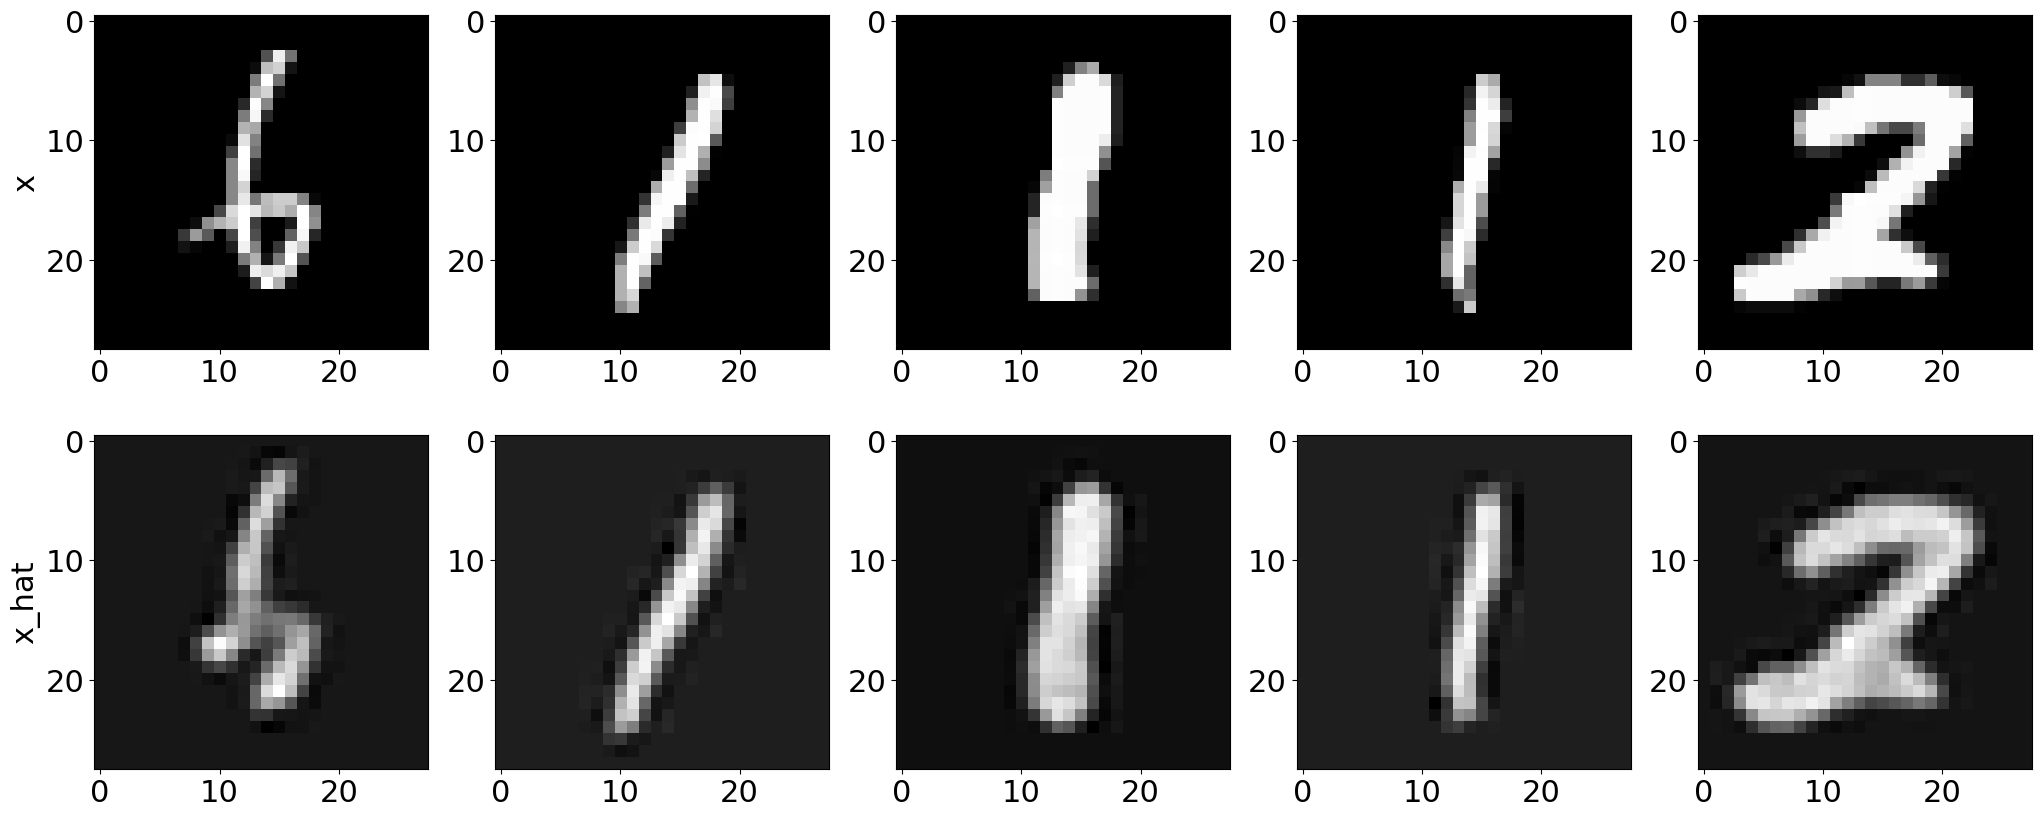

In [14]:
# Plot inputs and reconstructions.
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(2, NUM_SAMPLES, figsize=(25, 10))
for i in range(NUM_SAMPLES):
    ax[0][i].imshow(inputs[i], cmap='gray')
    ax[1][i].imshow(inputs_hat[i], cmap='gray')
text1 = ax[0][0].set_ylabel("x")
text2 = ax[1][0].set_ylabel("x_hat")

In [15]:
# Define constants
COEFF_SPARSITY = 7.5 # sparisty coefficient
COEFF_CONSISTENCY = 0 # consisteny coefficient -> no consistency
TRAIN_STEPS = 50000 # number of training steps -> consider increasing the number of steps
BATCH_SIZE = 100 # batch size

In [16]:
# Define explainer.
explainer = CounterfactualRL(predictor=predictor, encoder=encoder,decoder=decoder,
                             latent_dim=64, coeff_sparsity=COEFF_SPARSITY,coeff_consistency=COEFF_CONSISTENCY,
                             train_steps=TRAIN_STEPS,batch_size=64,backend="tensorflow")

In [17]:
explainer = explainer.fit(X=X_train)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [1:14:15<00:00, 11.22it/s]


In [18]:
# Generate counterfactuals for some test instances.
explanation = explainer.explain(X_test[0:200], Y_t=np.array([2]), batch_size=100)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.53it/s]


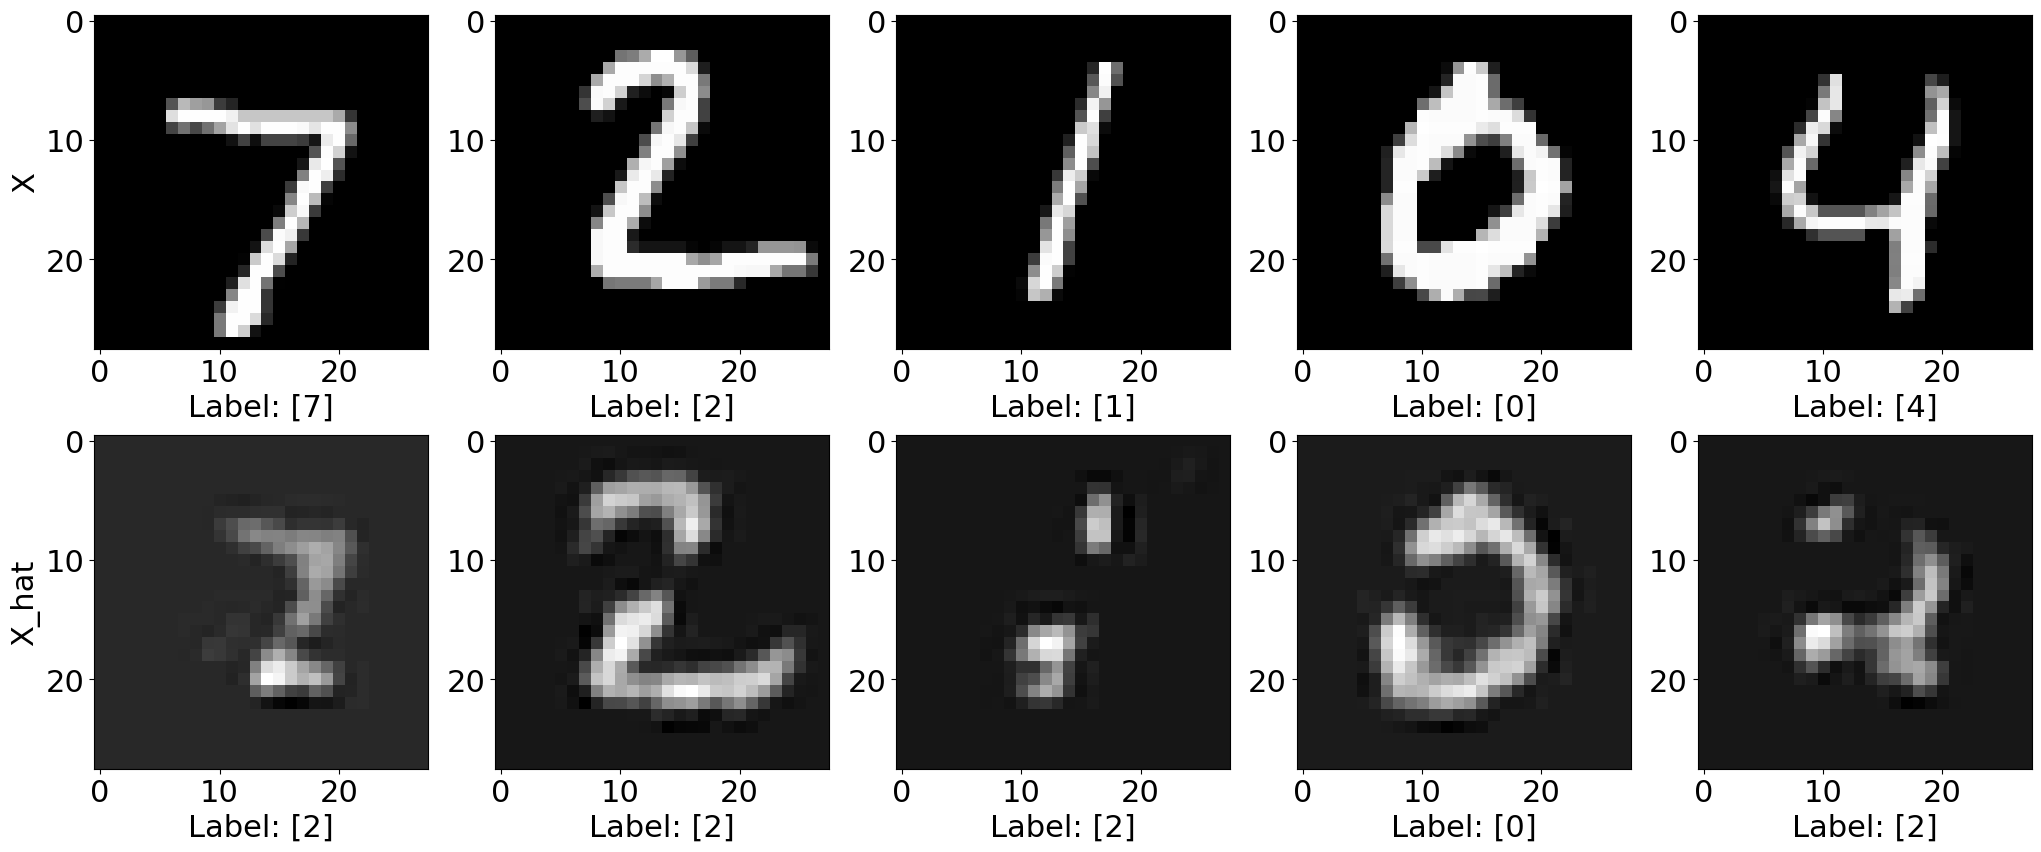

In [20]:
fig, ax = plt.subplots(2, NUM_SAMPLES, figsize=(25, 10))
for i in range(NUM_SAMPLES):
    ax[0][i].imshow(explanation.data['orig']['X'][i], cmap='gray')
    ax[1][i].imshow(explanation.data['cf']['X'][i], cmap='gray')
    ax[0][i].set_xlabel("Label: " + str(explanation.data['orig']['class'][i]))
    ax[1][i].set_xlabel("Label: " + str(explanation.data['cf']['class'][i]))
text1 = ax[0][0].set_ylabel("X")
text2 = ax[1][0].set_ylabel("X_hat")